## **8.3.2 드롭아웃을 이용한 성능 최적화**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm

In [4]:
!pip install torchvision


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
trainset = torchvision.datasets.FashionMNIST(root='/', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

100%|██████████████████████████████████████████████████████████████████| 26421880/26421880 [01:07<00:00, 388668.82it/s]


Extracting /FashionMNIST\raw\train-images-idx3-ubyte.gz to /FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 76576.65it/s]


Extracting /FashionMNIST\raw\train-labels-idx1-ubyte.gz to /FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 3888784.66it/s]


Extracting /FashionMNIST\raw\t10k-images-idx3-ubyte.gz to /FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 3910935.88it/s]

Extracting /FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to /FashionMNIST\raw



In [16]:
# 데이터셋을 메모리로 가져오기
batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [17]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /
    Split: Train
    StandardTransform
Transform: ToTensor()

In [25]:
# 데이터셋 분리
# 분리된 데이터셋에 대한 정보 확인
import numpy as np
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(images[0].shape)
print(labels[0].item())
# 이때 한번의 배치 크기로 4개의 데이터를 가져오고
# 흑백이미지이기 때문에 채널을 1로 (컬러라면 3임)
# 28x28 픽셀 크기의 이미지라는 뜻임

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
2


In [26]:
# 이미지 데이터를 출력하기 위한 전처리 함수
def imshow(img, title):    
    plt.figure(figsize=(batch_size * 4, 4)) # 출력할 개별 이미지의 크기를 지
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0))) # 이미지 데이터셋을 배치크기, 채널,높이 순서대로 파이토치는 지정하지만
    # matplotlib으로 출력하기 위해서는 너비, 높이, 채널 형태여야 하기 때문임
    plt.title(title)
    plt.show()

In [27]:
# 이미지 데이터 출력함수
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader)) # 이미지의 크기
    
    img = torchvision.utils.make_grid(images) # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 출력
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

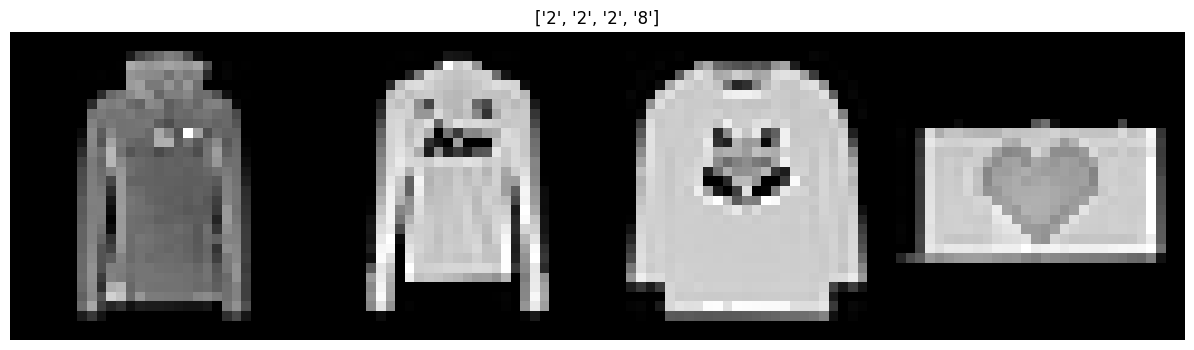

In [28]:
images, labels = show_batch_images(trainloader)

In [29]:
# 이때 batch size=4이기 때무에 한번의 배치에서 4개의 이미지만 가져옴
# 모델의 네트워크 구축을 할 때 배치 정규화가 적용된 모델과 비교를 위해 먼저 배치 정규화가 적용되지
# 않는 모델을 먼저 생
class NormalNet(nn.Module):
    def __init__(self): 
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10) # fashion 데이터에서 클래스는 총 10개 이므로
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x) # nn. Sequential 에서 정의한 계층 호출
        return x

In [30]:
# 배치 정규화가 적용된 네트워크 구축
class BNNet(nn.Module):
    def __init__(self): 
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48), # 배치 정규화가 적용되는 부분
            # 은닉층에서 학습이 진행 될 때마다 입력 분포가 변하면서 가중치가 엉뚱한 방향으로 갱신되는
            # 문제를 해결하기 위해 배치정규화로 입력 분포를 고르게 맞추기
            # 이때 배치정규화 는 완전 연결층과 합성곱층 뒤, 활성화 함수 앞에 위치해야 함
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [32]:
# 배치 정규화가 적용되지 않는 모델을 객체화
model = NormalNet()
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [34]:
# 배치 정규화가 적용된 모델 선언
model_bn = BNNet()
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [35]:
# 데이터셋을 메모리로 가져오기
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [36]:
# 이전에는 이미지 출력을 위해 배치크기가 4였지만 이번엔 512로 설정. 학습을 위한 용도니
# 옵티마이저와 손실함수 지정하기
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

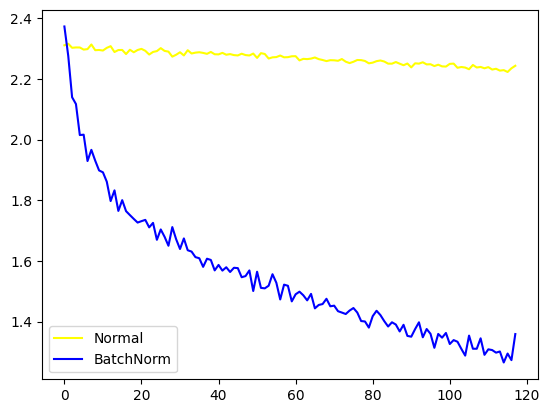

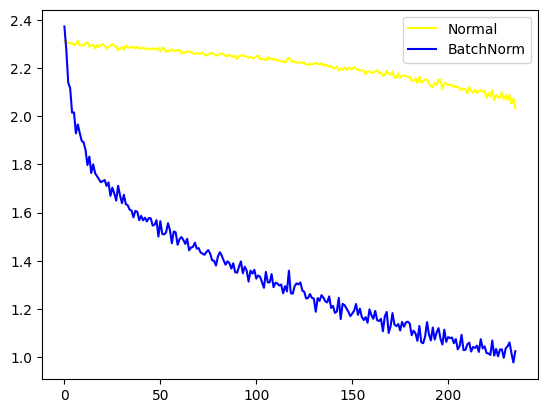

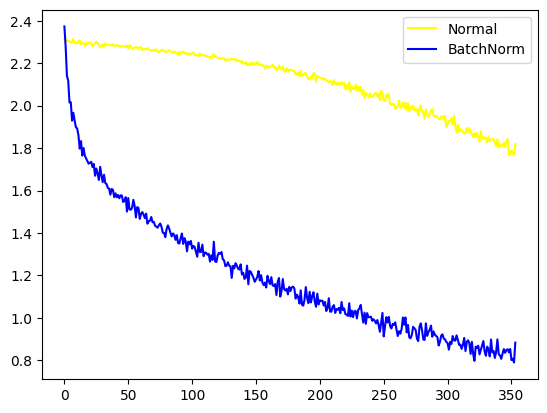

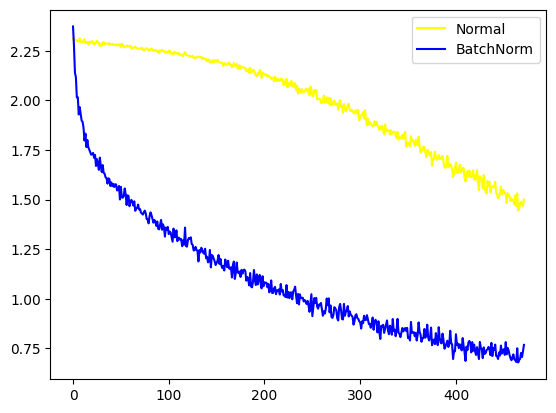

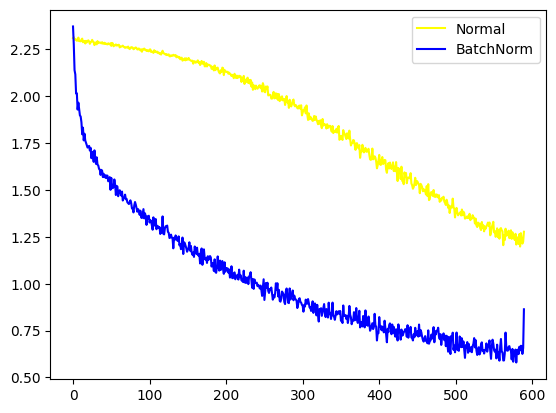

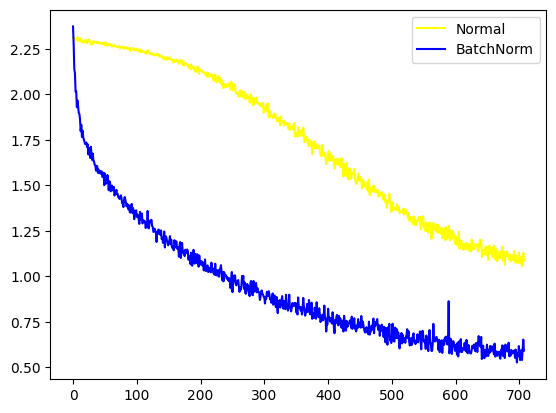

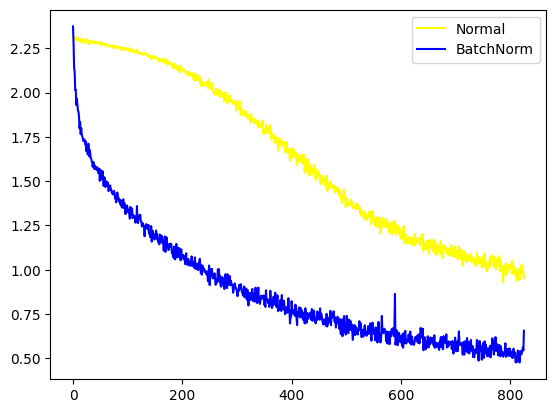

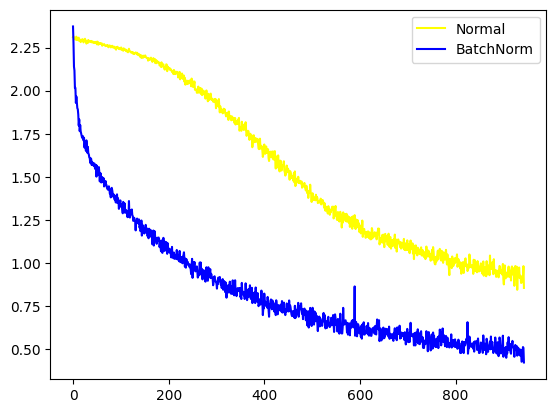

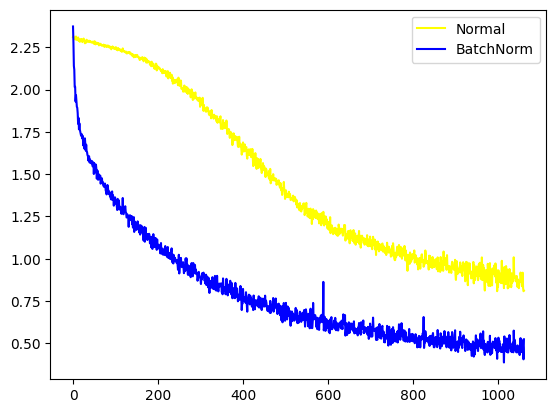

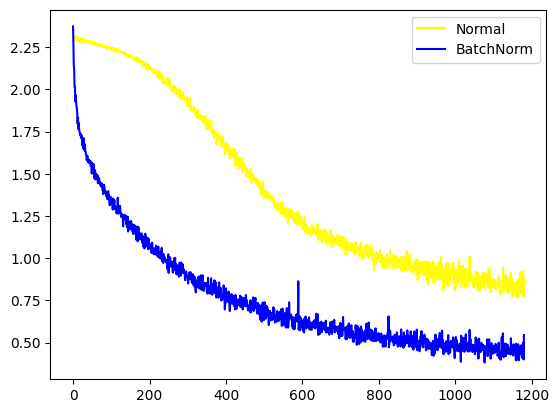

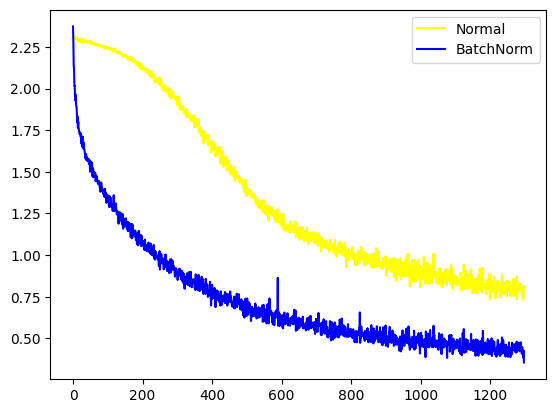

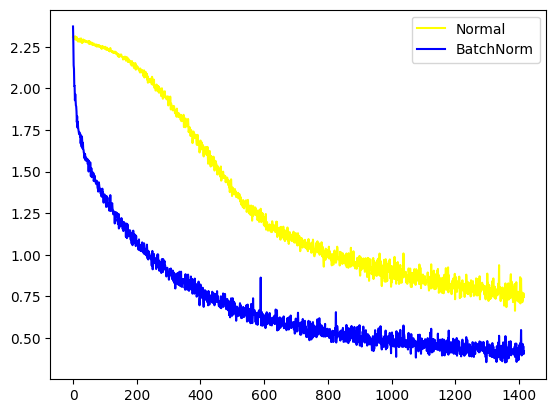

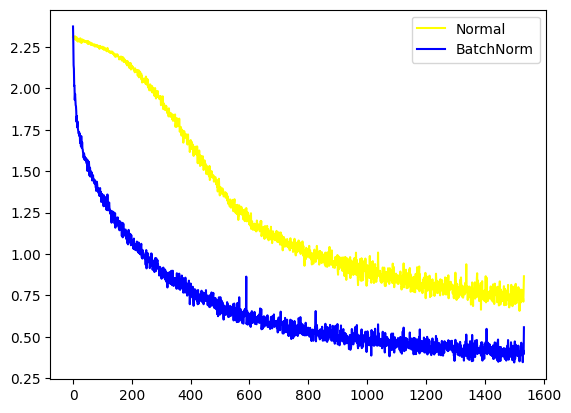

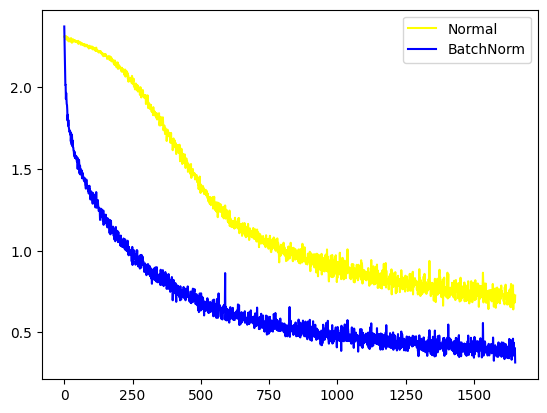

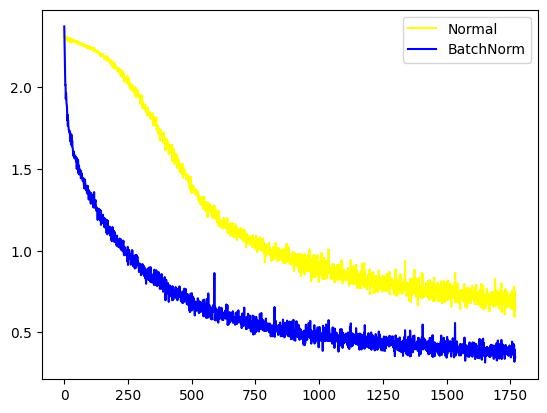

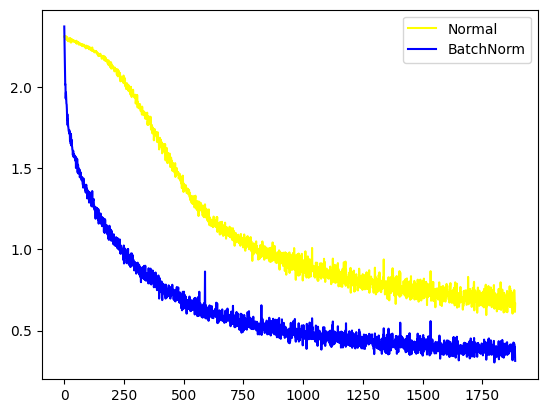

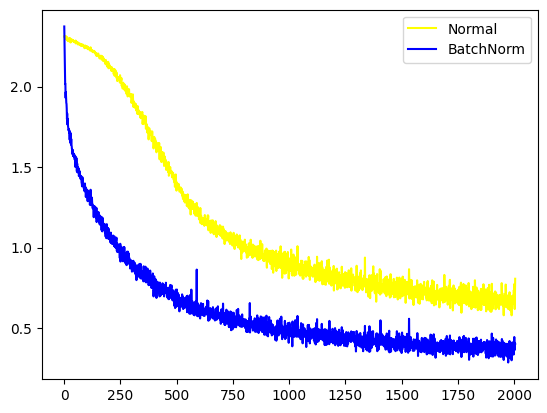

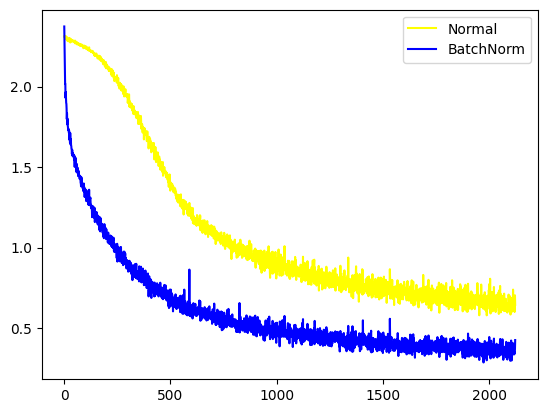

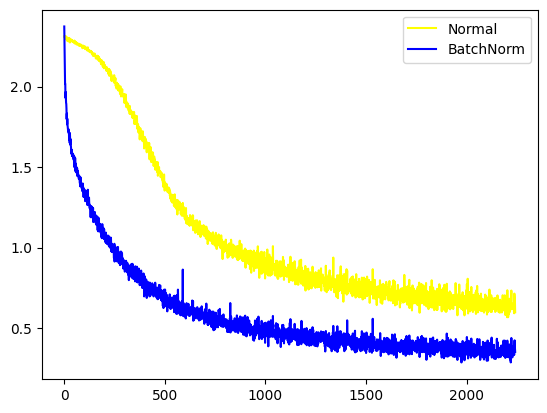

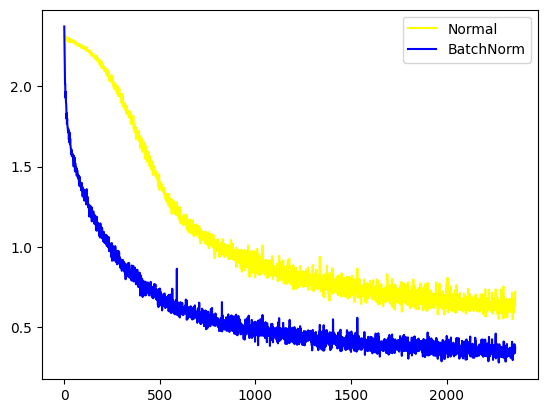

In [38]:
# 모델 학습
loss_arr = []
loss_bn_arr = []
max_epochs = 20

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs, labels
        opt.zero_grad()
        outputs = model(inputs)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
           
    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')    
    plt.legend()
    plt.show()

In [39]:
# 이때 나오는 그림은 모델의 학습 결과를 보여줌
# 배치 정규화가 적용된 모델일 수록 시간이 흐르면 오차가 줄어드는 것을 확인할 수 있음
# 따라서 더 안정적인 학습이 가능함
# 드롭아웃 설정해보기
# 훈련과 테스트 데이터셋이 어떻게 분포되어 있는지 확인하기
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1) # 훈련 데이터셋이 -1~1사이 값을 갖도록 함
# 이때 linspace를 통해 -1~1 범위에서 N개의 균등한 값을 갖는 텐서를 생성함
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
# 정규분포를 갖도록 조정함
x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
# 차원을 늘리기 위해 unsqueeze를 사용
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))


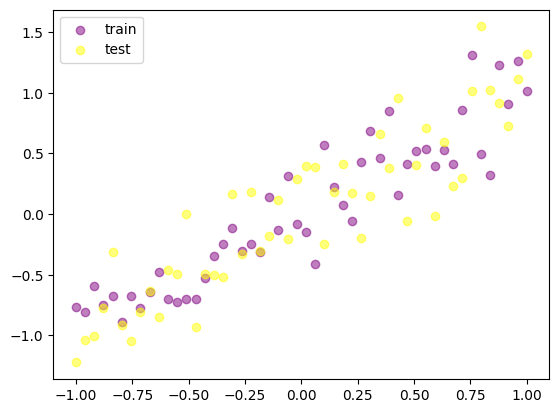

In [40]:
# 앞에서 전처리된 데이터를 그래프로 출력하여 분포를 확인
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [41]:
# 모두 고르게 분포되어 있는 것을 확인
# 드롭아웃 효과를 확인하기 위해 드롭아웃이 적용된 것과 그렇지 않은 모델을 생성
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [42]:
# 옵티마이저와 손실함수 지정
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

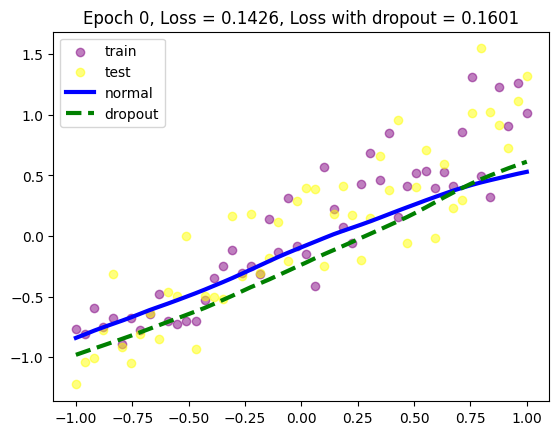

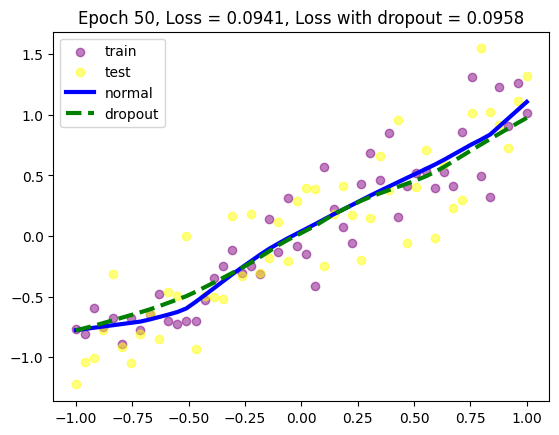

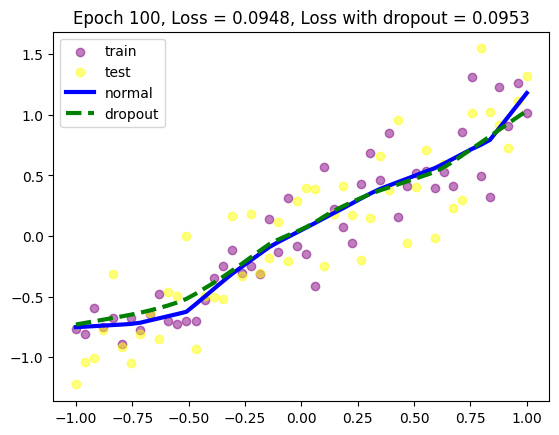

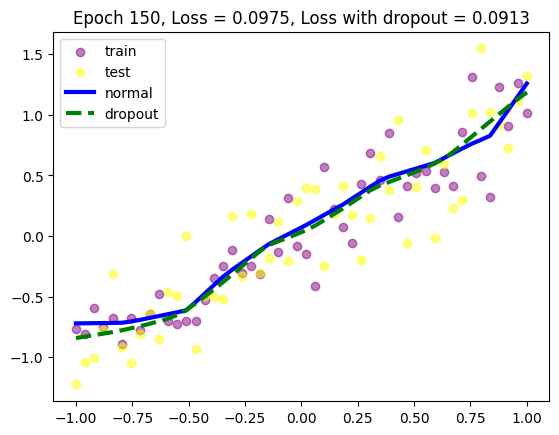

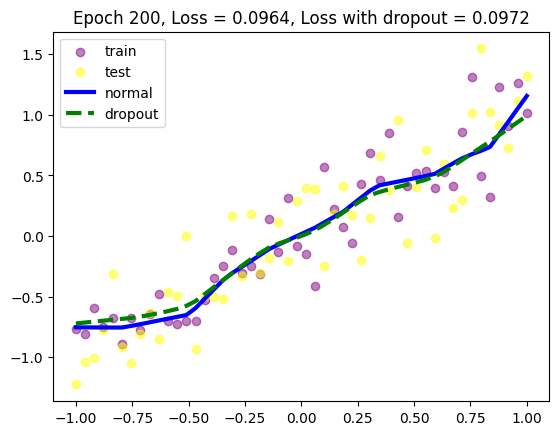

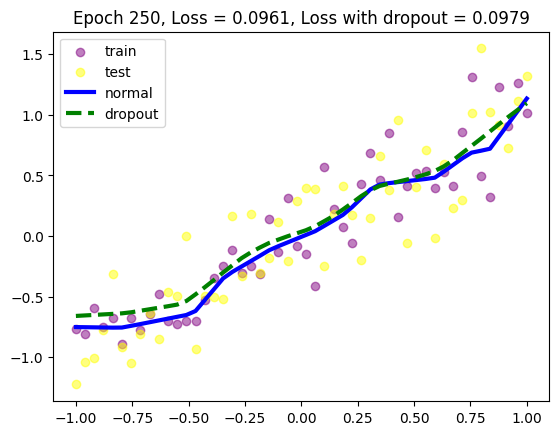

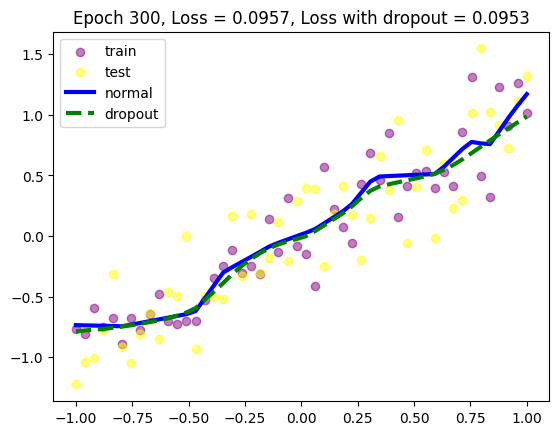

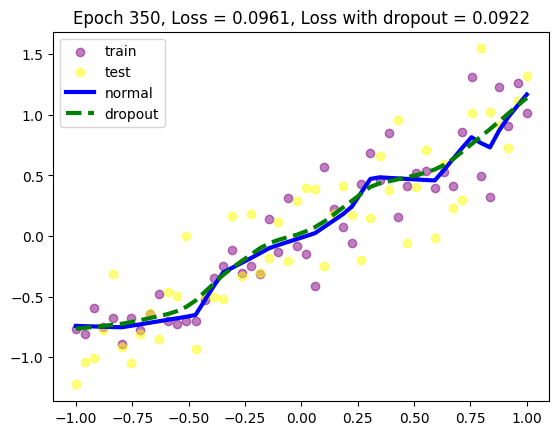

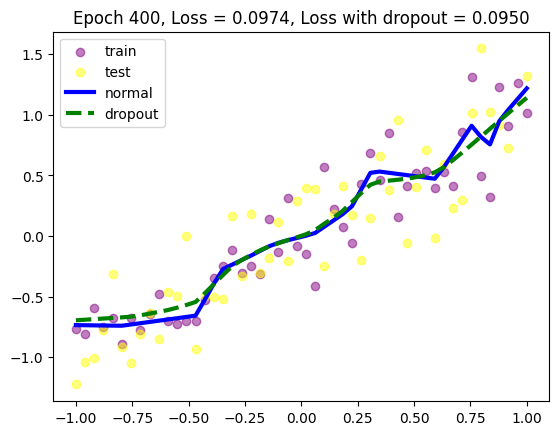

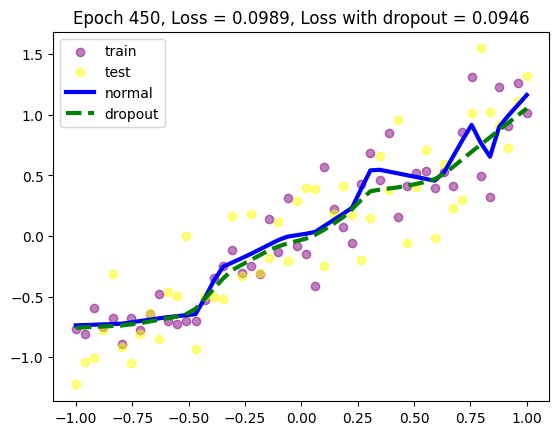

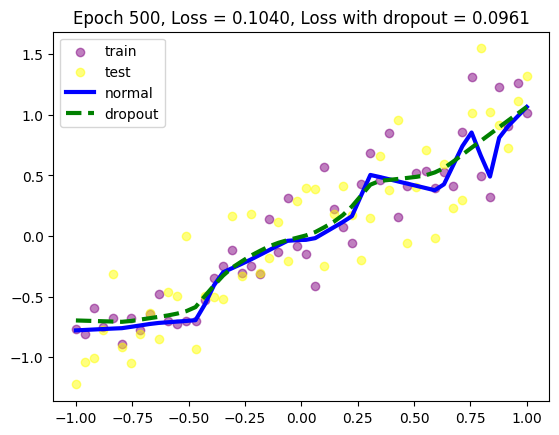

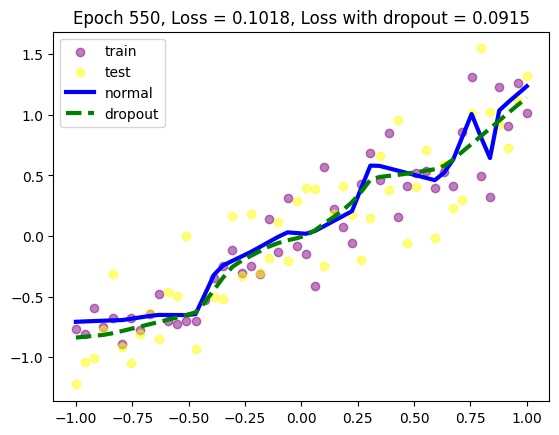

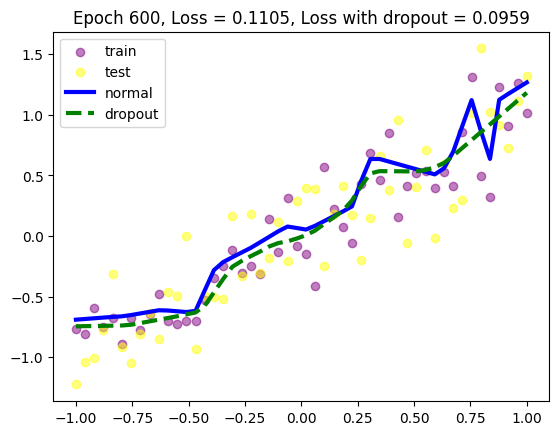

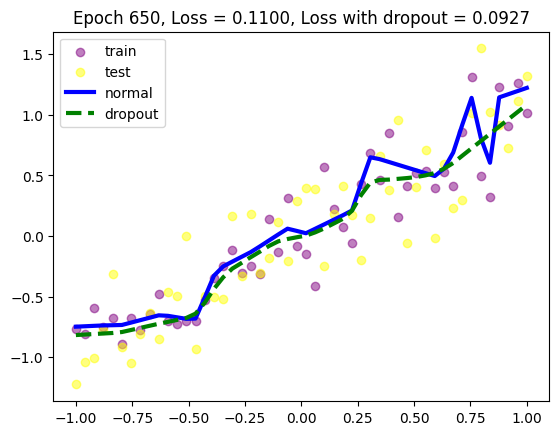

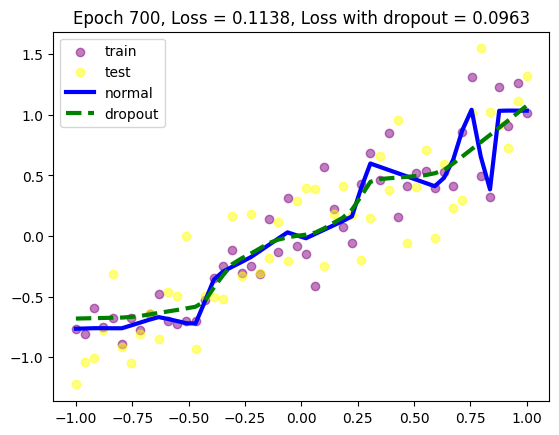

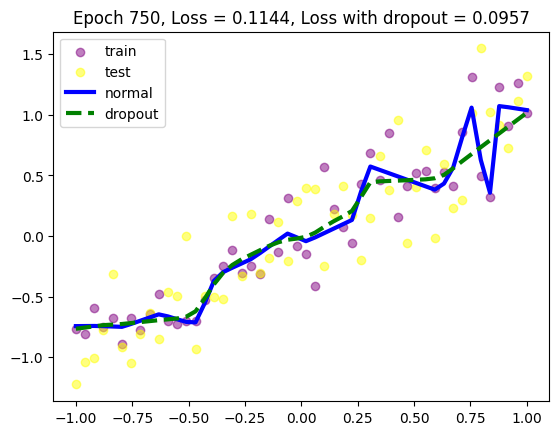

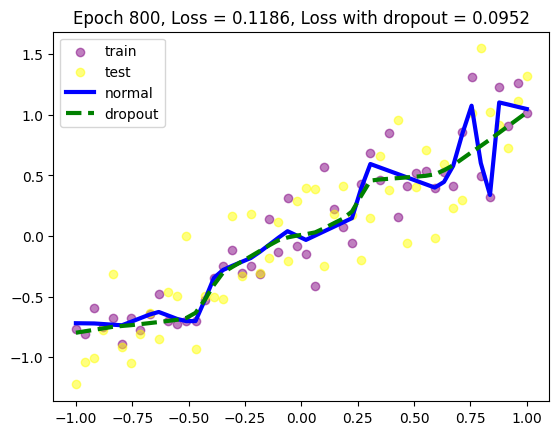

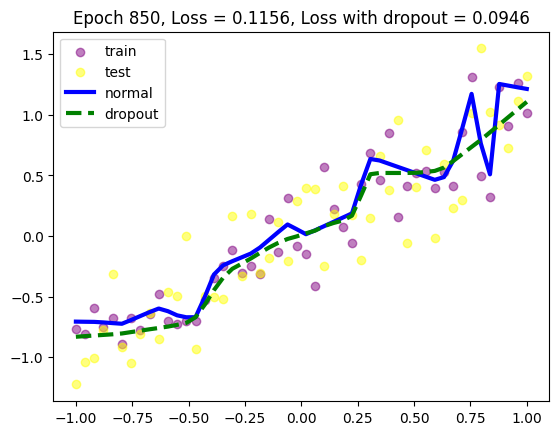

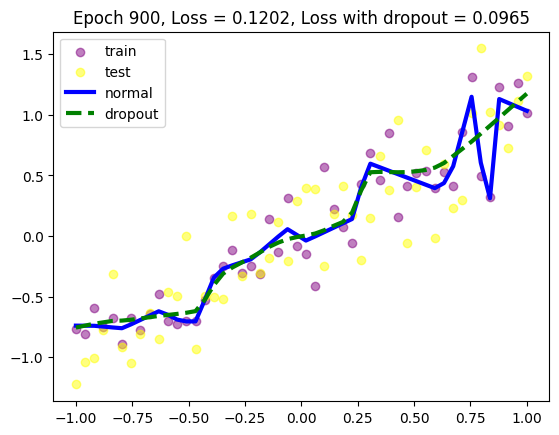

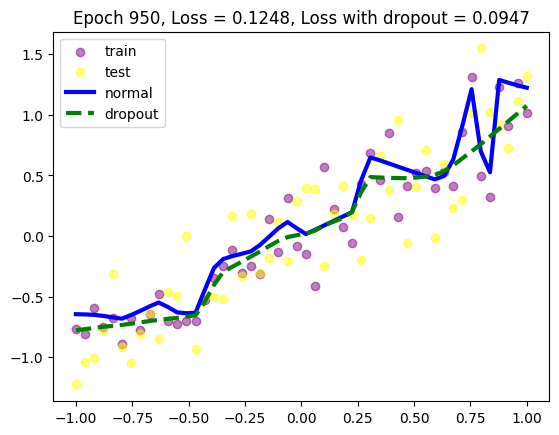

In [43]:
# 드롭 아웃이 적용된 모델과 그렇지 않는 모델을 학습시키기고
# 오차를 그래프로 출력하기
max_epochs = 1000
for epoch in range(max_epochs):    
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()    
    
    if epoch % 50 == 0:        
        model.eval()
        model_dropout.eval()
        
        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)
        
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()        
        plt.pause(0.05)

In [44]:
# 전반적으로 오차 줄어드는 범위가 크지는 않지만 드롭아웃을 적용했을 때
# 오차가 더 낮은 것이 확인이 됨
# 훈련 횟수가 증가할 수록 파란색 실선이 자주색 점과 자주 접하게 되는데, 이는 과적합 을 의미함
# 드롭아웃을 적용한 초록색 실선이 보다 일반적인 성능이 좋다는 것을 확인할 수 있음

## **8.3.3 조기종료를 이용한 성능 최적화**

In [45]:
# 필요한 라이브러러리 호출
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [46]:
# 데이터셋 전처리
# 핫도그와 핫도그가 아닌 이미지 사용
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [47]:
# 데이터셋 가져오기
train_dataset = datasets.ImageFolder(
    root=r"C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap08/data/archive/train",
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=r"C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap08/data/archive/test",
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

In [48]:
# 네트워크를 직접 구축하는 것이 아닌 사전 학습된 ResNet 50을 사용
def resnet50(pretrained=True):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2)
    return model

In [50]:
# 조기종료와 함께 사용할 learning rate decay를 통해
# 학습률에 대한 값을 고정시켜 모델을 학습시키는 것이 아닌
# 학습이 진행되는 과정에서 학습률을 조금씩 낮추어 주는 성능 튜닝 기법임
# 이때 learning rate scheduler를 이용해 학습률을 감소시키는데
# 주어진 patience의 횟수 만큼 validation loss에 오차 감소가 없음녀 factor 만큼 학습률을 감소시켜
# 모델 학습의 최적화가 가능하도록 도와주는 것
class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
            # validation loss에 대한 변동이 없으면 learning rate를 factor배로 감소시킴
                self.optimizer,
            # 가중치를 갱신하는 부분
                mode='min',
            # validtion loss 가 min이 될 대 학습률을 조정하도록
            # 조정 기준이 validation accuracy인 경우 max로 해야함
                patience=self.patience,
            # 학습률을 업데이트 하기 전에 몇번의 에포크를 기다려야 하는지 결정
                factor=self.factor,
            # 학습률을 얼마나 감소시킬 지 xfactor 만큼이 됨
                min_lr=self.min_lr,
            # 학습률의 하한선을 지정함
                verbose=True
            # 조기종료의 시작과 끝을 출력하기 위해
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [53]:
# 조기종료에 대한 클래스
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path='"C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap08/data/checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None # 검증 데이터셋에 대한 오차가 가장 낮은 값
        self.early_stop = False # 조기종료를 의미
        self.val_loss_min=np.Inf 
        self.delta = delta 
        self.path = path # 모델이 저장될 경로
        
    def __call__(self, val_loss, model): # 에포크만큼 학습이 반복되면서 best_loss가 갱신되고
        # best loss에 진전이 없으면 조기종료한 후 모델을 저장함
        score = -val_loss

        if self.best_score is None: # best score에 값이 존재하지 않으면 실행됨
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta: # best score+delta가 score보다 크면 실행됨
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model): # validation loss가 감소하면 모델을 저장함
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [54]:
# 인수 값 지정하기
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1") #주피터 노트북에서 실행할때 필요합니다
args = vars(parser.parse_args())

In [57]:
# 사전훈련된 모델의 파라미터 확인하기
# cpu를 사용할 것
# 학습 가능한 파라미터 수 출력
model = models.resnet50(pretrained=True)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

25,557,032 total parameters.
25,557,032 training parameters.


In [58]:
# 옵티마이저와 손실함수 지정
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [59]:
# 어떤 인수도 사용하지 않을 때 오차 정확도 모델의 이름으로 사용할 문자열을 지정
loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
model_name = 'model'

In [61]:
if args['lr_scheduler']:
    # 학습률 감소를 적용했을 때 오차, 정확도, 모델에 대한 문자열
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss'
    acc_plot_name = 'lrs_accuracy'
    model_name = 'lrs_model'
if args['early_stopping']:
    # 조기종료를 적용했을 때 오차, 정확도, 모델에 대한 문자열
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss'
    acc_plot_name = 'es_accuracy'
    model_name = 'es_model'

In [64]:
# 모델 학습 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [65]:
# 모델 검증 함수
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [ ]:
# 모델 학습시키기
# 훈련 데이터셋을 이용한 오차, 정확도를 저장하기 위한 변수 리스트
train_loss, train_accuracy = [], []
# 검증 데이터셋을 이용한 오차, 정확도를 저장하기 위한 변수 리스트
val_loss, val_accuracy = [], []
start = time.time()
epochs = 5
# CPU 사용하기 때문에 에포크 수를 줄이기
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 5
Training


16it [10:32, 39.52s/it]                                                                                                


Validating


16it [03:33, 13.35s/it]                                                                                                


Train Loss: 1.4989, Train Acc: 65.86
Val Loss: 30.9233, Val Acc: 36.60
Epoch 2 of 5
Training


16it [11:57, 44.87s/it]                                                                                                


Validating


16it [03:34, 13.43s/it]                                                                                                


Train Loss: 0.5615, Train Acc: 71.29
Val Loss: 6.4228, Val Acc: 54.40
Epoch 3 of 5
Training


16it [10:52, 40.81s/it]                                                                                                


Validating


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [02:20<01:10, 14.16s/it]

In [ ]:
# 모델 정확도와 오차를 그래프를 통해서 확인하기
plt.figure(figsize=(10, 7))
# 훈련 데이터셋에 대한 정확도 그래프 출력
plt.plot(train_accuracy, color='green', label='train accuracy')
# 검증 데이터셋에 대한 정확도 그래프 출력
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"../chap08/img/{acc_plot_name}.png")
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
# 훈련 데이터셋에 대한 오차 그래프 출력
# 검증 데이터셋에 대한 오차 그래프 출력
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"../chap08/img/{loss_plot_name}.png")
plt.show()

# 모델 저장하는 코드
# print('Saving model...')
# torch.save(model.state_dict(), f"../chap08/img/{model_name}.pth")
# print('TRAINING COMPLETE')